<a href="https://colab.research.google.com/github/shaytanne/runi-reinforcement_learning-assignment2/blob/branch_Yossi/MidProject_tabular_RL_Minigrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mid Semester Project - Reinforcements Learning 2025
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1:
<br>
Student 2:
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Installs

In [41]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install imageio
!pip install pyvirtualdisplay
!pip install gymnasium
!pip install minigrid
!pip install pygame

# Imports

In [42]:
# 1. Future Imports (Must be first)
from __future__ import annotations

# 2. Standard Library Imports
import base64
import copy
import random

# 3. Third-Party Data & Visualization Imports
import imageio
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import HTML
import pyvirtualdisplay

# 4. Gymnasium Imports
import gymnasium as gym
from gymnasium import spaces

# 5. Minigrid Imports
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.minigrid_env import MiniGridEnv as BaseMiniGridEnv

# --- Configuration ---

# Configure Matplotlib for Notebook Environment
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [43]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Env

In [44]:
# =============================================================================
# CONSTANTS & MAPPINGS
# =============================================================================
# These dictionaries map object names to integer IDs for the observation tensor.
# This ensures the neural network receives consistent numerical representations.
OBJECT_TO_IDX = {
    "unseen": 0, "empty": 1, "wall": 2, "floor": 3, "door": 4,
    "key": 5, "ball": 6, "box": 7, "goal": 8, "lava": 9, "agent": 10,
}
IDX_TO_OBJECT = {i: name for name, i in OBJECT_TO_IDX.items()}
COLOR_TO_IDX = {name: i for i, name in enumerate(COLOR_NAMES)}
IDX_TO_COLOR = {i: name for i, name in enumerate(COLOR_NAMES)}

# =============================================================================
# BASE ENVIRONMENT WRAPPER
# =============================================================================
class MiniGridEnv(BaseMiniGridEnv):
    """
    A compatibility wrapper around the modern gymnasium-minigrid BaseMiniGridEnv.
    It handles default MissionSpace initialization which is required in newer versions
    but often unused in simple RL tasks.
    """
    def __init__(
        self,
        grid_size=None,
        width=None,
        height=None,
        max_steps=10000,
        see_through_walls=False,
        agent_view_size=7,
        render_mode=None,
        mission_space=None,
        **kwargs
    ):
        # Newer Minigrid versions strictly require a MissionSpace.
        # We provide a dummy default if one isn't passed.
        if mission_space is None:
            mission_space = MissionSpace(mission_func=lambda: "do something")

        super().__init__(
            grid_size=grid_size,
            width=width,
            height=height,
            max_steps=max_steps,
            see_through_walls=see_through_walls,
            agent_view_size=agent_view_size,
            render_mode=render_mode,
            mission_space=mission_space,
            **kwargs
        )

    def reset(self, *, seed=None, options=None):
        return super().reset(seed=seed, options=options)

In [45]:
# =============================================================================
# ENVIRONMENT 1: RANDOM EMPTY GRID
# =============================================================================
class RandomEmptyEnv_10(MiniGridEnv):
    """
    A 10x10 grid environment with no obstacles inside, just outer walls.
    The agent and goal start positions are randomized within specific constraints.
    """
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        render_mode="rgb_array",
        **kwargs,
    ):
        self.init_agent_pos = agent_start_pos
        self.init_agent_dir = agent_start_dir

        # Define a static mission string (not used by the agent typically)
        mission_space = MissionSpace(mission_func=self._gen_mission)

        # Heuristic for max steps: typically enough to explore the grid fully
        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True, # Agent has full observability of the room
            max_steps=max_steps,
            render_mode=render_mode,
            **kwargs,
        )
        # Discrete actions: 0: Turn Left, 1: Turn Right, 2: Move Forward
        self.action_space = spaces.Discrete(3)
        self.walls_init = []
        # Default goal position (overwritten in _gen_grid)
        self.goal_pos = (self.width - 2, self.height - 2)

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def reset(self, *, seed=None, options=None):
        # 1. Randomize agent starting parameters before generating the grid
        self.agent_start_pos = (random.randint(1, 6), random.randint(1, 6))
        self.agent_start_dir = random.choice([0, 1, 2, 3])

        # 2. Call parent reset, which internally calls _gen_grid()
        return super().reset(seed=seed, options=options)

    def _gen_grid(self, width, height):
        """
        Procedurally generates the grid layout: walls, goal, and agent.
        """
        self.grid = Grid(width, height)

        # 1. Create the outer boundary walls
        self.grid.wall_rect(0, 0, width, height)

        # 2. Place internal walls (if any defined in self.walls_init)
        for column, row in self.walls_init:
            self.grid.set(column, row, Wall())

        # 3. Randomize Goal Position (Top-Right, Bottom-Right, Bottom-Left corners roughly)
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # 4. Place Agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

    def step(self, action):
        """
        Standard step function with Sparse Reward modification.
        """
        obs, reward, terminated, truncated, info = super().step(action)

        # Sparse Reward: Only reward 1.0 upon reaching the goal (termination)
        if terminated:
            reward = 1.0
        else:
            reward = 0.0

        return obs, reward, terminated, truncated, info

    # Getters for wrapper compatibility
    def get_k_pos(self): return getattr(self, 'key_pos', None)
    def get_d_pos(self): return getattr(self, 'door_pos', None)
    def get_goal_pos(self): return self.goal_pos


In [46]:
# =============================================================================
# ENVIRONMENT 2: RANDOM KEY & DOOR
# =============================================================================
class RandomKeyMEnv_10(MiniGridEnv):
    """
    A 10x10 grid separated into two rooms by a vertical wall (partition).
    The agent must find a key, open a locked door in the partition, and reach the goal.
    """
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        render_mode="rgb_array",
        partition_col=3, # Column index where the dividing wall is placed
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir
        self.partition_col = partition_col
        self.walls_init = []

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        """
        Generates: Outer walls -> Partition Wall -> Door -> Key -> Goal.
        """
        # 1. Create empty grid and outer walls
        self.grid = Grid(width, height)
        self.grid.wall_rect(0, 0, width, height)

        # 2. Define Partition Wall and Door Location
        # Choose a random row for the door (pass_loc)
        self.pass_loc = random.choice([op_row for op_row in range(1, height-1)])
        # Create a vertical wall at partition_col
        self.walls_init = [(self.partition_col, i) for i in range(0, height)]

        # Place the partition wall objects
        for column, row in self.walls_init:
            if 0 <= column < width and 0 <= row < height:
                self.grid.set(column, row, Wall())

        # 3. Place Key and Door
        # Key is placed randomly in the left room (columns 1 to partition_col)
        self.key_pos = (
            random.choice([k_col for k_col in range(1, self.partition_col)]),
            random.choice([k_row for k_row in range(2, height-1)])
        )
        self.door_pos = (self.partition_col, self.pass_loc)

        # Place the Locked Door (replaces the wall at pass_loc)
        self.env_door = Door(COLOR_NAMES[0], is_locked=True)
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)

        # Place the Key
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))

        # 4. Place Goal (Randomly in the right upper or lower corner)
        self.goal_pos = random.choice([(8,1), (8,8)])
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # 5. Place Agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

    def step(self, action):
        # Standard step with sparse reward logic
        obs, reward, terminated, truncated, info = super().step(action)
        if terminated:
            reward = 1.0
        else:
            reward = 0.0
        return obs, reward, terminated, truncated, info

    # Getters
    def get_k_pos(self): return self.key_pos
    def get_d_pos(self): return self.door_pos
    def get_goal_pos(self): return self.goal_pos


# Wrappers

In [47]:
# =============================================================================
# OBSERVATION WRAPPER
# =============================================================================
class KeyFlatObsWrapper(gym.ObservationWrapper):
    """
    Transforms the observation from a 2D image/grid to a 1D flat vector.
    """
    def __init__(self, env):
        super().__init__(env)

        # Define observation space:
        # We strip the outer walls (width-2, height-2).
        # Each cell has 3 attributes (Object ID, Color ID, State/Direction).
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),
            dtype='uint8'
        )
        self.get_init_map()

    def observation(self, obs):
        """
        Process the grid state into a flat vector.
        """
        env = self.unwrapped

        # 1. Get the full numerical encoding of the grid
        full_grid = env.grid.encode()

        # 2. Inject Agent State
        # Minigrid's 'encode()' often treats the agent separately.
        # Here, we overwrite the grid cell at agent_pos with agent details.
        if env.agent_pos is not None:
            full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
                OBJECT_TO_IDX['agent'],
                COLOR_TO_IDX['red'],
                env.agent_dir
            ])

        # 3. Crop Outer Walls
        # Slicing [1:-1, 1:-1] removes the standard boundary walls to reduce dim.
        full_grid = full_grid[1:-1, 1:-1]

        # 4. Flatten to 1D array
        return full_grid.ravel()

    # --- Helper methods for Analysis / Debugging ---

    def is_carrying_key(self):
        """Check if the agent is currently holding the key object."""
        return self.unwrapped.carrying is not None and self.unwrapped.carrying.type == 'key'

    def is_door_open(self):
        """Check the state of the specific environment door."""
        if hasattr(self.unwrapped, 'env_door') and self.unwrapped.env_door:
            return self.unwrapped.env_door.is_open
        return False

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_goal_pos(self):
        return self.unwrapped.goal_pos

    def get_init_map(self):
        """
        Creates a binary map (walls vs empty) of the environment structure.
        Used for visualization or pathfinding heuristics.
        """
        env = self.unwrapped
        # Note: Minigrid uses (x, y), numpy uses (row, col) -> (y, x).
        map_u = np.zeros((env.height, env.width), dtype=int)

        # Mark outer walls
        map_u[0, :] = 1
        map_u[-1, :] = 1
        map_u[:, 0] = 1
        map_u[:, -1] = 1

        # Mark inner walls
        if hasattr(env, 'walls_init'):
            for x, y in env.walls_init:
                if 0 <= y < env.height and 0 <= x < env.width:
                    map_u[y, x] = 1

        self.init_map = map_u.tolist()

    def get_updated_map(self):
        """
        Returns a character-based map (ASCII) showing the current state
        of entities (Agent 'P', Goal 'G', Door 'D', Key 'K').
        """
        current_map = copy.deepcopy(self.init_map)

        # 1. Place Agent ('P' for Player)
        ax, ay = self.unwrapped.agent_pos
        current_map[ay][ax] = 'P'

        # 2. Place Goal ('G')
        gx, gy = self.unwrapped.goal_pos
        current_map[gy][gx] = 'G'

        # 3. Place Door ('D') if closed
        if hasattr(self.unwrapped, 'door_pos') and not self.is_door_open():
            dx, dy = self.unwrapped.door_pos
            current_map[dy][dx] = 'D'

        # 4. Place Key ('K') if not carried
        if hasattr(self.unwrapped, 'key_pos') and not self.is_carrying_key():
            kx, ky = self.unwrapped.key_pos
            current_map[ky][kx] = 'K'

        return current_map

# RandomEmptyEnv_10

**Description**:

This environment is an empty room, and the goal of the agent is to reach the green goal square.

Agent position at begining is random.


Direction of the agent at begining is random.


Goal position could be: (8,1) or (1,8) or (8,8).

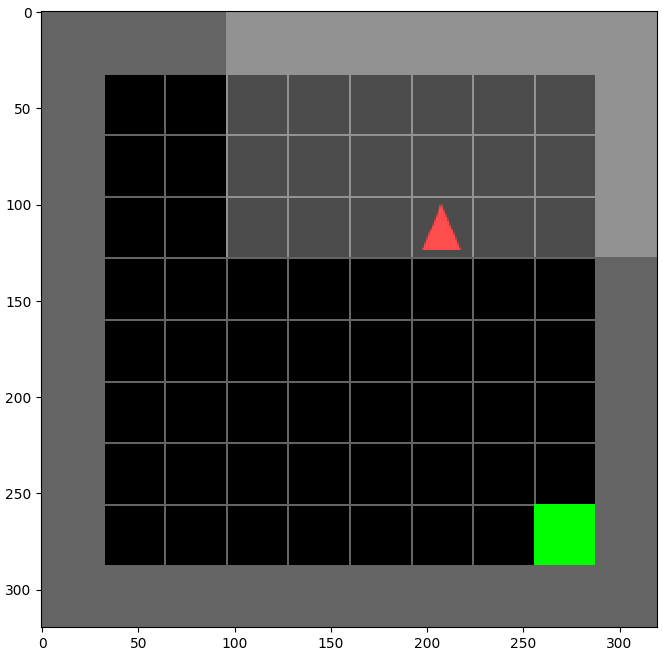

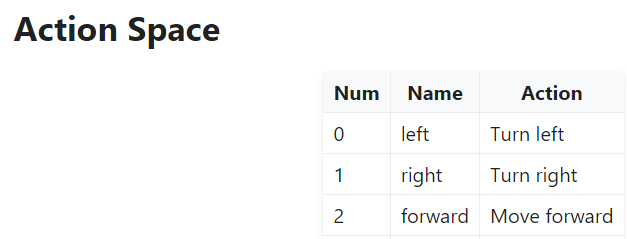

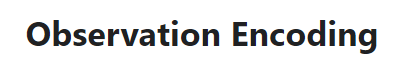

Agent Direction,
Agent Position,
Goal Position

Observation: (array([ 1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,
        0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
        0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,
        1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,
        0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
        0,  0, 10,  4,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,
        1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,
        0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
        0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,
        1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  8,  1,
        0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
        0,  0,  1,  0,  0], dtype=uint8), {})

Agent position  (4, 6)
Agent direction  0
If Agent is carrying:  False
Goal position:  (8, 1)
number of actions po

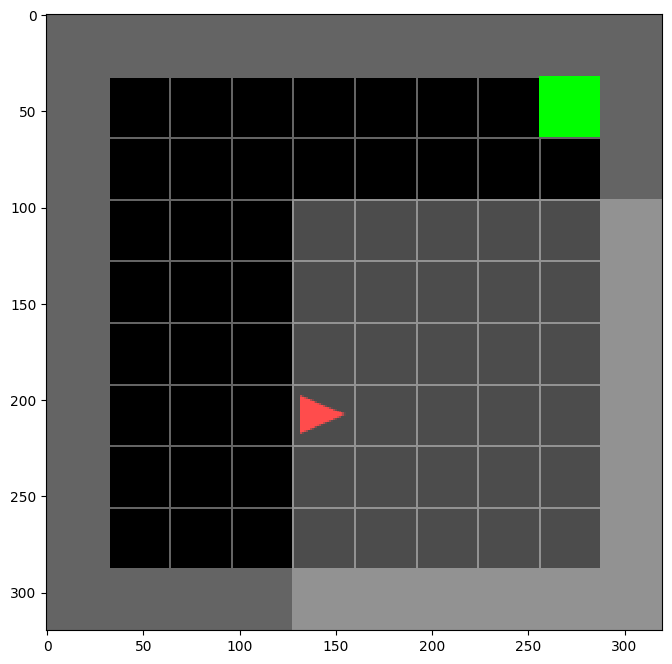

In [48]:
env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array', max_steps=100))
obs = env.reset()
print("Observation:", obs)
print()
print("Agent position ", env.get_position())
print("Agent direction ", env.get_direction())
print("If Agent is carrying: ", env.is_carrying_key())
print("Goal position: ", env.get_goal_pos())
print("number of actions possible: ", env.action_space.n)
print()
screen = env.render()
plt.imshow(screen)

In [49]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")


Number of actions: 3


In [50]:
# obs = env.reset()
# # ============================================
# screen = env.render()
# plt.imshow(screen)
print('Map Height:', env.unwrapped.height-2)
print('Map Width:', env.unwrapped.width-2)
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Goal position: ', env.get_goal_pos())
# print('Carrying Key:', env.is_carrying_key())
# print('Door Open:', env.is_door_open())

Map Height: 8
Map Width: 8
Agent Direction: 0
Agent Position: (4, 6)
Goal position:  (8, 1)


In [51]:
#Random action plus visualization
max_steps = 100
env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array', max_steps=max_steps))
obs = env.reset()
video_filename = '/content/fn.mp4'

with imageio.get_writer(video_filename, fps=10) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = random.randint(0, num_actions - 1)
      obs, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated #
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(env.render())
      if done:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

done reward= 0 num_of_steps= 74


# RandomKeyMEnv_10

### Description

This environment has a key that the agent must pick up in order to unlock a goal and then get to the green goal square.

- Wall is always in the third column.

- Key is always in the left part (left to the door).

- Goal is randomly in the right upper or lower corner.

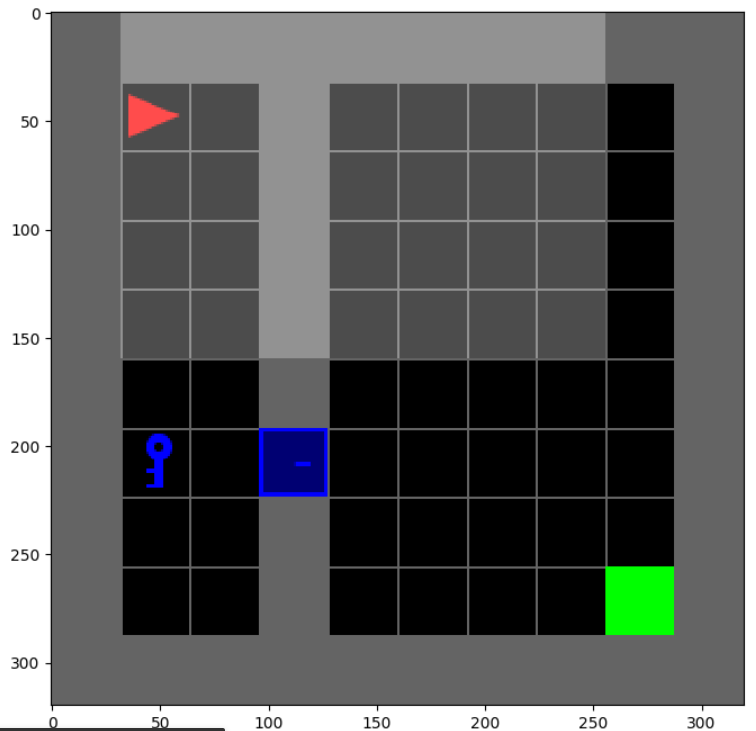

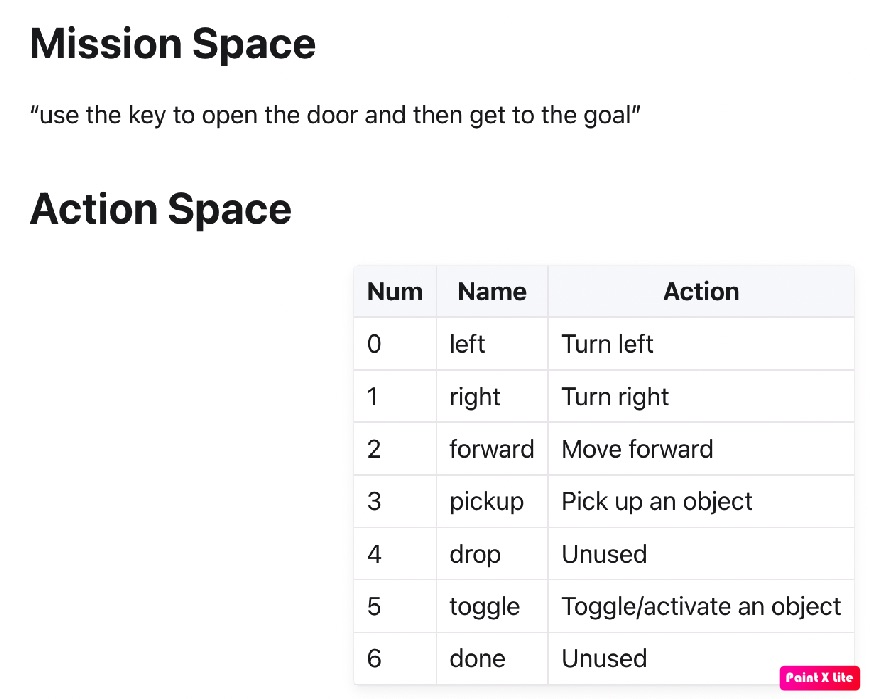

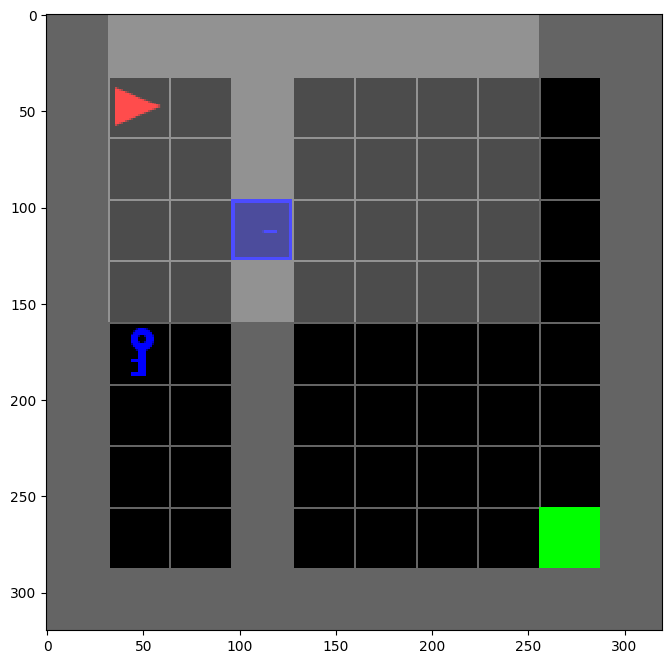

In [52]:
#=============== DO NOT DELETE ===============
# random.seed(42)
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array', max_steps=100))

obs = env.reset()
# ============================================
screen = env.render()
plt.imshow(screen)

In [53]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")

Number of actions: 7


In [54]:
# env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
# obs = env.reset()
# ============================================
# screen = env.render()
# plt.imshow(screen)
print('Map Height:', env.unwrapped.height-2)
print('Map Width:', env.unwrapped.width-2)
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Goal position: ', env.get_goal_pos())
print('Carrying Key:', env.is_carrying_key())
print('Door Open:', env.is_door_open())

Map Height: 8
Map Width: 8
Agent Direction: 0
Agent Position: (1, 1)
Goal position:  (8, 8)
Carrying Key: False
Door Open: False


# Your Code Below

# Imports

In [55]:
from abc import ABC, abstractmethod
import numpy as np
import gymnasium as gym
from minigrid.minigrid_env import MiniGridEnv
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
from typing import Any, List, Tuple, Optional, Callable

# State Handler

### Explaining the main idea behind the class

#### Otimization points
$\text{Things we need to consider are the state space representation, it could be that our state space is too large, and need to determine our observation space}$

In [56]:
# ==========================================
# State Representation Component
# ==========================================
class StateHandler:
    """
    Handles conversion of MiniGrid observations to discrete (integer) states
    Mapping: (AgentX, AgentY, Direction, HoldingStatus) -> unique int
    """
    def __init__(self, env: MiniGridEnv, track_carrying: bool = False):
        self.width = env.width
        self.height = env.height
        self.track_carrying = track_carrying

        # If we're in the base environment we have to also consider 3 goals options
        self.num_states: int = (self.width * self.height) * 4 * 3

        # If we're in the Key environment then we keep track if the agent is:
        # 1. Carrying the key or not - x2
        # 2. The goal-position is constant but the door is #OfRows options (in 3rd Column) - x(self.height)
        if self.track_carrying:
            self.num_states = (self.width * self.height) * 4 * self.height * 2

    def get_state_index(self, env: MiniGridEnv) -> int:
        """
        Extracts state index from env instance
        """
        x, y = env.agent_pos
        direction = env.agent_dir

        # Optimization: Shift coordinates to ignore outer walls (0 and width-1)
        # Reachable inner grid is (width-2) x (height-2)
        adj_x, adj_y = x - 1, y - 1
        inner_w, inner_h = self.width - 2, self.height - 2

        # Base Physical Index (256 states for 10x10 env)
        base_idx = (adj_y * inner_w + adj_x) * 4 + direction

        goal_pos = env.get_goal_pos()
        goal_map = {(8, 1): 0, (1, 8): 1, (8, 8): 2}
        goal_id = goal_map.get(goal_pos, 0)

        total_physical_states = inner_w * inner_h * 4
        state_idx = base_idx + (goal_id * total_physical_states)

        # handle carrying status if tracked (update state_idx)
        if self.track_carrying and env.carrying is not None:
            state_idx += (total_physical_states * 3)

        return int(state_idx)

    def get_num_states(self) -> int:
        return self.num_states

    def get_readable_state(self, state_idx: int) -> Tuple[int, int, int, int]:
        """
        Reverse mapping for debugging: index -> (x, y, dir, is_carrying)
        """
        # handle carrying status
        carrying_offset = (self.width * self.height * 4)
        is_carrying = 0
        if self.track_carrying and state_idx >= carrying_offset:
            is_carrying = 1
            state_idx -= carrying_offset

        # extract direction + position
        direction = state_idx % 4
        position_idx = state_idx // 4

        # extract x, y (the <x * height + y> part)
        y = position_idx % self.height
        x = position_idx // self.height

        return (x, y, direction, is_carrying)

# Base Agent Class

### All Algorithms will inherit this components

In [166]:
# ==========================================
# Base class for Agent Components
# ==========================================
class BaseAgent(ABC):
    """
    Base class for all Tabular RL agents
    Handles Q-table init, action selection, hyperparameters
    """
    def __init__(self, num_states: int, num_actions: int, lr: float = 0.1, gamma: float = 0.99, epsilon: float = 0.1):
        self.n_states = num_states
        self.n_actions = num_actions
        self.lr = lr            # learning rate (alpha)
        self.gamma = gamma      # discount factor
        self.epsilon = epsilon  # exploration rate

        # init Q-table
        # random init # todo: consider other inits optoins
        self.q_table = np.random.uniform(low=0, high=0.01, size=(num_states, num_actions))
        # Initialise all values to 1 enable better exploration
        self.q_table = np.ones((num_states, num_actions))
        #self.q_table = np.zeros((num_states, num_actions))

    def choose_action(self, state_idx: int, force_greedy: bool = False) -> int:
        """
        Epsilon-greedy action selection
        :param state_idx: current state index
        :param force_greedy: controls exploration (ignores epsilon) for inference/testing
        :return : selected action index
        """
        if not force_greedy and np.random.uniform(0, 1) < self.epsilon:
            # explore:
            selected_action = np.random.randint(0, self.n_actions)
            return int(selected_action)
        else:
            # exploit:
            values = self.q_table[state_idx]                        # get Q-table row for current state
            best_actions = np.flatnonzero(values == values.max())   # get all actions with max Q-value (1 or more)
            selected_action = np.random.choice(best_actions)        # break ties randomly (if multiple best)
            return int(selected_action)

    @abstractmethod
    def update(self, *args) -> None:
        # todo: implement by inheriting classes
        raise NotImplementedError("This method should be overridden by subclasses")

    def save_q_table(self, filename: str = "q_table.pkl") -> None:
        """Util for saving Q-table to file"""
        with open(filename, "wb") as f:
            pickle.dump(self.q_table, f)

    def load_q_table(self, filename: str = "q_table.pkl") -> None:
        """Util for loading Q-table from file"""
        with open(filename, "rb") as f:
            self.q_table = pickle.load(f)

# Q-Learning



In [58]:
class QLearningAgent(BaseAgent):
    def update(self, state: int, action: int, reward: float, next_state: int, done: bool) -> None:
        """
        Q-Learning update (off-policy):
        Q(s,a) <- Q(s,a) + alpha * [reward + gamma * max(Q(s',a')) - Q(s,a)]
        """
        max_next_q = np.max(self.q_table[next_state]) if not done else 0.0
        td_target = reward + self.gamma * max_next_q

        current_q = self.q_table[state][action]
        self.q_table[state][action] += self.lr * (td_target - current_q)

# SARSA

In [59]:
class SARSAAgent(BaseAgent):
    def update(self, state: int, action: int, reward: float, next_state: int, next_action: int, done: bool) -> None:
        """
        SARSA update (On-Policy):
        Q(s,a) <- Q(s,a) + alpha * [reward + gamma * Q(s',a') - Q(s,a)]
        """
        next_q = self.q_table[next_state][next_action] if not done else 0.0
        td_target = reward + self.gamma * next_q

        current_q = self.q_table[state][action]
        self.q_table[state][action] += self.lr * (td_target - current_q)


# Monte-Carlo

#### On Policy first-visit MC control (for $\epsilon$-soft policies), estimates $\pi \approx \pi_*$



In [60]:
class MCAgent(BaseAgent):
    def __init__(self, n_states: int, n_actions: int, lr: float = 0.1, gamma: float = 0.99, epsilon: float = 0.1):
        super().__init__(n_states, n_actions, lr, gamma, epsilon)
        # MC needs to store returns for averaging
        self.returns_sum = defaultdict(float)
        self.returns_count = defaultdict(float)
        self.episode_buffer: List[Tuple[int, int, float]] = []

    def store_transition(self, state: int, action: int, reward: float) -> None:
        """Store each step for processing at end of episode"""
        step = (state, action, reward)
        self.episode_buffer.append(step)

    def update(self) -> None:
        """
        MC update:
        - executed at END of an episode
        - iterates backwards through episode buffer
        """
        G: float = 0.0 # cumulative return
        visited_pairs = set()

        # traverse episode backwards
        for state, action, reward in reversed(self.episode_buffer):
            G = self.gamma * G + reward

            # first-visit MC check
            if (state, action) not in visited_pairs:
                visited_pairs.add((state, action))

                # rolling mean update: Q(s,a) = Q(s,a) + alpha * (G - Q(s,a))
                # todo: consider 1/n returns avg instead of const alpha
                old_q = self.q_table[state][action]
                self.q_table[state][action] += self.lr * (G - old_q)

        self.episode_buffer = [] # clear buffer

# Experimenting

In [167]:

class ExperimentRunner:
    """
    Manages training loop, logging, env interaction
    """
    def __init__(self, env: gym.Env, agent: BaseAgent, state_handler: StateHandler, max_steps: int = 100,
                 reward_shaping_func: Optional[Callable] = None):
        self.env = env
        self.agent = agent
        self.state_handler = state_handler
        self.max_steps = max_steps
        self.reward_shaping_func = reward_shaping_func

        # metrics
        self.rewards_history = []
        self.steps_history = []

    def run_training(self, num_episodes: int, print_info: bool = False) -> Tuple[List[float], List[int]]:
        WINDOW = 100
        EPS = 1e-2
        for episode in range(num_episodes):
            obs, _ = self.env.reset()

            # Sanity check that the goals are random

            # print("Goal at start of chunk: ", env.get_goal_pos())

            # unwrap to MiniGridEnv for the state handler
            mg_env: MiniGridEnv = self.env.unwrapped  # error here is ok (typing)

            state = self.state_handler.get_state_index(mg_env)


            total_reward: float = 0.0
            steps = 0
            done = False
            truncated = False   # indicates if episode ended w/o reaching done state

            # SARSA needs the initial action
            if isinstance(self.agent, SARSAAgent):
                action = self.agent.choose_action(state)

            while not any([done, truncated]) and steps < self.max_steps:

                if not isinstance(self.agent, SARSAAgent):
                    action = self.agent.choose_action(state)

                # step env
                next_obs, reward, done, truncated, info = self.env.step(action)
                next_state = self.state_handler.get_state_index(mg_env)

                # reward shaping hook for KeyEnv ( if provided)
                if self.reward_shaping_func:
                    reward = self.reward_shaping_func(float(reward), mg_env, done, info)

                # update agent
                if isinstance(self.agent, QLearningAgent):
                    self.agent.update(
                        state=state,
                        action=action,
                        reward=float(reward),
                        next_state=next_state,
                        done=done
                    )

                elif isinstance(self.agent, SARSAAgent):
                    next_action = self.agent.choose_action(next_state)
                    self.agent.update(
                        state=state,
                        action=action,
                        reward=float(reward),
                        next_state=next_state,
                        next_action=next_action,
                        done=done
                    )
                    action = next_action # SARSA: update current action for next loop

                elif isinstance(self.agent, MCAgent):
                    self.agent.store_transition(
                        state=state,
                        action=action,
                        reward=float(reward)
                    )

                state = next_state
                total_reward += float(reward)
                steps += 1

            # end of episode update for MC
            if isinstance(self.agent, MCAgent):
                self.agent.update()

            # history update
            self.rewards_history.append(total_reward)
            self.steps_history.append(steps)

            # decay epsilon
            self.agent.epsilon = max(0.005, self.agent.epsilon * 0.995)

            if print_info and episode % 100 == 0:
                print(f"Episode {episode}: Steps={steps}, Reward={total_reward:.2f}, Epsilon={self.agent.epsilon:.3f}")

        return self.rewards_history, self.steps_history

    def close(self) -> None:
        self.env.close()



In [62]:
def evaluate(env, agent, state_handler, episodes=100):
    rewards = []
    steps = []

    old_epsilon = agent.epsilon
    agent.epsilon = 0.0  # greedy

    for _ in range(episodes):
        obs, _ = env.reset()
        mg_env = env.unwrapped
        state = state_handler.get_state_index(mg_env)

        total_reward = 0
        for step in range(100):
            action = agent.choose_action(state, force_greedy=True)
            _, reward, done, truncated, _ = env.step(action)
            state = state_handler.get_state_index(mg_env)
            total_reward += reward
            if done or truncated:
                break

        rewards.append(total_reward)
        steps.append(step + 1)

    agent.epsilon = old_epsilon
    return rewards, steps

# Sanity Tests

In [63]:
# Create the environment
env_empty = KeyFlatObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array', max_steps=100))
env_key = KeyFlatObsWrapper(RandomKeyMEnv_10(render_mode='rgb_array', max_steps=100))

# Initialize StateHandler
sh_empty = StateHandler(env_empty.unwrapped, track_carrying=False)
sh_key = StateHandler(env_key.unwrapped, track_carrying=True)

# Reset environments
obs_empty = env_empty.reset()
obs_key = env_key.reset()

# Get discrete state indices
state_idx_empty = sh_empty.get_state_index(env_empty.unwrapped)
state_idx_key = sh_key.get_state_index(env_key.unwrapped)

# Print results
print("RandomEmptyEnv_10:")
print("Agent pos:", env_empty.get_position())
print("Direction:", env_empty.get_direction())
print("State index:", state_idx_empty)
print("Total states:", sh_empty.get_num_states())
print("The range of states are: ", sh_empty.get_num_states()-1)


print("\nRandomKeyEnv_10:")
print("Agent pos:", env_key.get_position())
print("Direction:", env_key.get_direction())
print("Carrying key:", env_key.is_carrying_key())
print("State index:", state_idx_key)
print("Total states:", sh_key.get_num_states())

RandomEmptyEnv_10:
Agent pos: (2, 2)
Direction: 0
State index: 548
Total states: 1200
The range of states are:  1199

RandomKeyEnv_10:
Agent pos: (1, 1)
Direction: 0
Carrying key: False
State index: 0
Total states: 8000


## Testing state transitions

In [64]:
env = KeyFlatObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array', max_steps=100))
sh = StateHandler(env.unwrapped, track_carrying=False)

env.reset()
s0 = sh.get_state_index(env.unwrapped)

env.step(2)   # move forward
s1 = sh.get_state_index(env.unwrapped)

print("s0:", s0)
print("s1:", s1)
print("Changed:", s0 != s1)

s0: 370
s1: 366
Changed: True


## Testing action effects explicitely

In [65]:
env.reset()

print("Before:", env.get_position(), env.get_direction())
env.step(0)   # turn left
print("After left:", env.get_position(), env.get_direction())

env.step(2)   # forward
print("After forward:", env.get_position(), env.get_direction())

Before: (4, 1) 3
After left: (4, 1) 2
After forward: (np.int64(3), np.int64(1)) 2


### Testing state check

In [66]:
env.reset()

for _ in range(10):
    _, r, _, _, _ = env.step(2)
    print("Reward:", r)

Reward: 0.0
Reward: 0.0
Reward: 0.0
Reward: 0.0
Reward: 0.0
Reward: 0.0
Reward: 0.0
Reward: 0.0
Reward: 0.0
Reward: 0.0


# Empty Environment - Training and Evaluation

In [211]:
total_episodes = 1000
eval_interval = 100
eval_episodes = 10

# Set up
env = KeyFlatObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array', max_steps=100))
sh = StateHandler(env.unwrapped, track_carrying=False)

num_states = sh.get_num_states()
num_actions = env.action_space.n

agents = {
    # An Optimal Solution for MC
    "Monte Carlo": MCAgent(n_states=num_states, n_actions = num_actions, lr=0.5, gamma =0.9, epsilon = 1.0),
    # An Optimal Solution for Q-Learning
    "Q-Learning": QLearningAgent(num_states=num_states, num_actions=num_actions, lr=0.75, gamma=0.95, epsilon=1.0),
    # An Optimal Solution for SARSA
    "SARSA": SARSAAgent(num_states=num_states, num_actions=num_actions, lr=0.7, gamma = 0.9, epsilon=1.0)
}

inference_checkpoints = list(range(eval_interval, total_episodes + 1, eval_interval))

# Dictionary to store results for the report
results = {}

for name, agent in agents.items():
    print(f"\n--- Starting Training for {name} ---")


    runner = ExperimentRunner(
        env=env,
        agent=agent,
        state_handler=sh,
        max_steps=100,
        reward_shaping_func=None
    )

    all_train_rewards = []
    inference_avg_steps = []
    inference_avg_rewards = []

    for start_ep in range(0, total_episodes, eval_interval):
        # Training Phase
        train_rewards, _ = runner.run_training(eval_interval, print_info=True)
        all_train_rewards.extend(train_rewards)

        # Inference Phase (Greedy evaluation)
        eval_rewards, eval_steps = evaluate(env, agent, sh, episodes=eval_episodes)

        # Calculate and store the average for plotting
        avg_step = np.mean(eval_steps)
        avg_reward = np.mean(eval_rewards)

        inference_avg_steps.append(avg_step)
        inference_avg_rewards.append(avg_reward)

        print(f"Episode {start_ep + eval_interval} | Inference Avg Steps: {avg_step:.2f}")

    results[name] = {
        "train_rewards": all_train_rewards,
        "inference_steps": inference_avg_steps,
        "inference_rewards": inference_avg_rewards
    }

    # Clean up the runner for the next agent
    runner.close()


--- Starting Training for Monte Carlo ---
Episode 0: Steps=29, Reward=1.00, Epsilon=0.995
Episode 100 | Inference Avg Steps: 100.00
Episode 0: Steps=100, Reward=0.00, Epsilon=0.603
Episode 200 | Inference Avg Steps: 90.40
Episode 0: Steps=33, Reward=1.00, Epsilon=0.365
Episode 300 | Inference Avg Steps: 63.50
Episode 0: Steps=100, Reward=0.00, Epsilon=0.221
Episode 400 | Inference Avg Steps: 27.60
Episode 0: Steps=22, Reward=1.00, Epsilon=0.134
Episode 500 | Inference Avg Steps: 13.30
Episode 0: Steps=14, Reward=1.00, Epsilon=0.081
Episode 600 | Inference Avg Steps: 11.50
Episode 0: Steps=12, Reward=1.00, Epsilon=0.049
Episode 700 | Inference Avg Steps: 13.60
Episode 0: Steps=11, Reward=1.00, Epsilon=0.030
Episode 800 | Inference Avg Steps: 21.90
Episode 0: Steps=10, Reward=1.00, Epsilon=0.018
Episode 900 | Inference Avg Steps: 11.40
Episode 0: Steps=20, Reward=1.00, Epsilon=0.011
Episode 1000 | Inference Avg Steps: 11.90

--- Starting Training for Q-Learning ---
Episode 0: Steps=100,

# Graphs for comparison

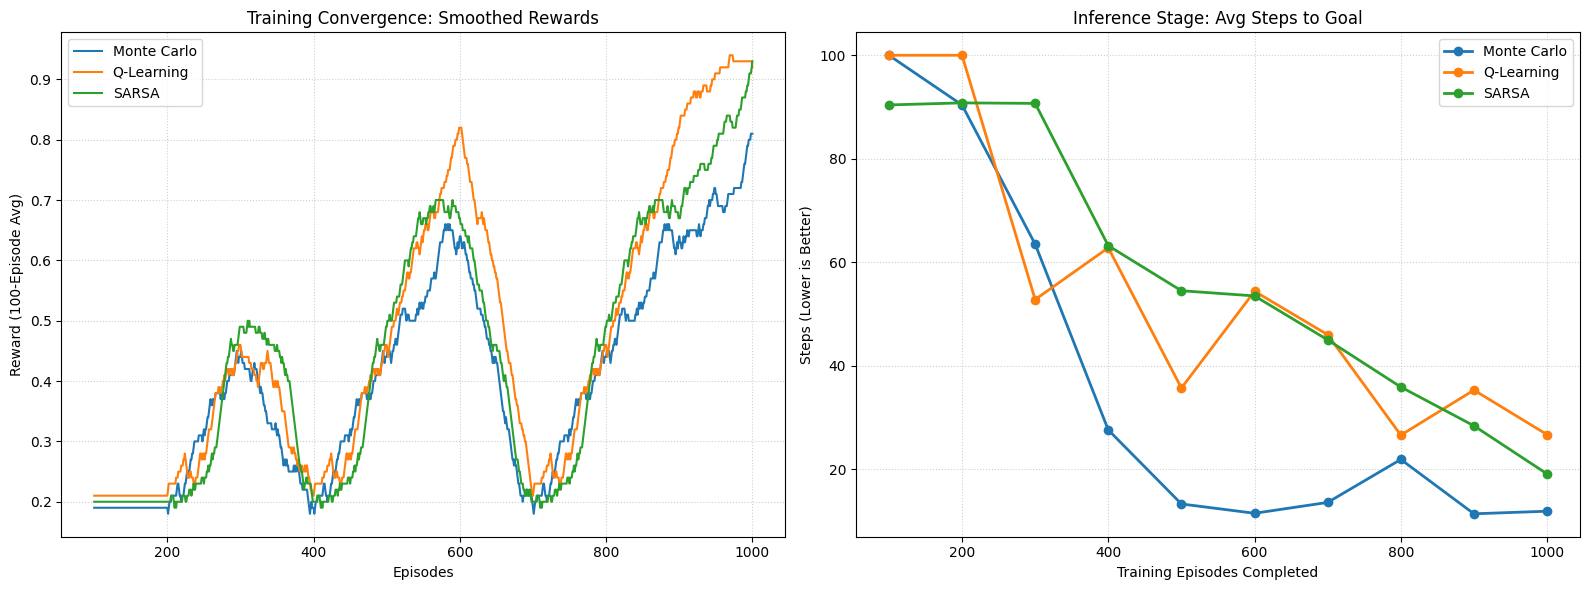

In [212]:
import matplotlib.pyplot as plt

def plot_rl_results(results, inference_checkpoints, window_size=100):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- Plot 1: Training Convergence (Rewards) ---
    for name, data in results.items():
        rewards = np.array(data["train_rewards"])

        if len(rewards) > 1000:
            rewards = rewards[:1000]

        if len(rewards) >= window_size:
            smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
            # Adjust x-axis to account for the moving average window offset
            x_axis = np.arange(window_size , len(rewards)+1)
            ax1.plot(x_axis, smoothed, label=f"{name}")
        else:
            ax1.plot(rewards, label=f"{name} (raw)", alpha=0.3)

    ax1.set_title("Training Convergence: Smoothed Rewards")
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel(f"Reward ({window_size}-Episode Avg)")
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.6)

    # --- Plot 2: Inference Efficiency (Steps) ---
    for name, data in results.items():
        # Ensure x (checkpoints) and y (inference_steps) have the same length
        ax2.plot(inference_checkpoints, data["inference_steps"], marker='o', linewidth=2, label=name)

    ax2.set_title("Inference Stage: Avg Steps to Goal")
    ax2.set_xlabel("Training Episodes Completed")
    ax2.set_ylabel("Steps (Lower is Better)")
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    # Saving plots when needed
    plt.savefig("NonExploringEffect.png")
    plt.show()

plot_rl_results(results, inference_checkpoints)

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
